<a href="https://colab.research.google.com/github/mahyarbolhassan/Deep-Learning/blob/main/Image_Captioning_ResNet_glove50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [3]:
%cd gdrive/My Drive/Projects

/content/gdrive/My Drive/Projects


In [ ]:
# %rm -rf /content/gdrive/MyDrive/Projects/flickr8k_text

In [ ]:
# !unzip flicker8k-dataset.zip 

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
import string
import json
from time import time
import pickle
from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.utils import pad_sequences
from keras.utils import to_categorical
from keras.layers import Input, Dense, Dropout, Embedding, LSTM
from keras.layers import add
from os import listdir
from pickle import dump
from keras.utils import load_img
from keras.utils import img_to_array

# Read Captions File

#### We are going to use Flicker 8k dataset for the image captioning problem in our project. Based on the dataset, for each individual image, there are five different descriptions. The fact behide having different captions is to educate the model about different way to describe an image while all of them are correct. 

##### Therefore, we start our implementation with opening the file namad token which contains all the descriptions.

In [5]:
# Reading the Description file

with open("/content/gdrive/MyDrive/Projects/Flickr8k_text/Flickr8k.token.txt") as filepath:
    captions = filepath.read()
    filepath.close()

##### in order to seperate each of the descriptions we can seperate them by lines, because each descriptions accompanied by its image code in one line.

In [6]:
captions = captions.split("\n")[:-1]

##### By printing the number of descriptions, it shows that there are 40460 lines or captions

In [7]:
len(captions)

40460

##### Now that we seperate each caption by lines, we need to categorize them according to thier associate image code. Thus, we start with a dictionary where the image name is considered the dictionary key, while the value of the dictionary is the list of those cations that are for a specific image. 

In [8]:
# creating a "descriptions" dictionary  where key is 'img_name' and value is list of captions corresponding to that image_file.

descriptions = {}

for caption in captions:
    i_to_c = caption.split("\t")
    img_name = i_to_c[0].split(".")[0]
    cap = i_to_c[1]
    
    if descriptions.get(img_name) == None:
        descriptions[img_name] = []
        

    descriptions[img_name].append(cap)

The result can be seen below. For each image in the data we have five different captions.

In [10]:
descriptions['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [11]:
descriptions['1000268201_693b08cb0e'][0]

'A child in a pink dress is climbing up a set of stairs in an entry way .'

# Data Cleaning

In this part, our aim is to clean the text (descriptions) in order to feed it into the model. There are couple of things that we have done, converting all letters into lowercase, removing punctuations, and removing words that have the length less than one. 

Those operations are the one that we considered for our model, but it is not restricted to them.

In [12]:
""" 1. lower each word
    2. remove puntuations
    3. remove words less than length 1 """ 

def clean_text(sample):
    sample = sample.lower()
    
    sample = re.sub("[^a-z]+"," ",sample)
    
    sample = sample.split()
    
    sample = [s for s in sample if len(s)>1]
    
    sample = " ".join(sample)
    
    return sample

In [13]:
clean_text("My noghsujf si am m cricket101 &8 mphi*&86%%&??,BY6fajdn 213 q rqu243 boy  32 ewr wO>>J DHD 34  asfb HHGY Gvg HgB   231 123")

'my noghsujf si am cricket mphi by fajdn rqu boy ewr wo dhd asfb hhgy gvg hgb'

Now is the time to apply the cleaning function to the descriptions that we obtained earlier from our data.

In [14]:
#  modify all the captions i.e - cleaned captions

for key, desc_list in descriptions.items():
    for i in range(len(desc_list)):
        desc_list[i] = clean_text(desc_list[i])

The line code below shows how the descriptions of an example image has been clean.

In [15]:
#  clean descriptions

descriptions['1000268201_693b08cb0e']

['child in pink dress is climbing up set of stairs in an entry way',
 'girl going into wooden building',
 'little girl climbing into wooden playhouse',
 'little girl climbing the stairs to her playhouse',
 'little girl in pink dress going into wooden cabin']

Thus, we create a text file and save all cleaned captions.

In [16]:
# writing clean description to .txt file

f = open("descriptions.txt","w")
f.write( str(descriptions) )
f.close()

In [17]:
#  reading description file

f = open("/content/gdrive/MyDrive/Projects/descriptions.txt", 'r')
descriptions = f.read()
f.close()

json_acceptable_string = descriptions.replace("'", "\"")
descriptions = json.loads(json_acceptable_string)

In order to find the dictionary of the data, we find the unique vocabularies in the description file.

In [18]:
vocabulary = set()

for key in descriptions.keys():
    [vocabulary.update(i.split()) for i in descriptions[key]]

print('Vocabulary Size: %d' % len(vocabulary))

Vocabulary Size: 8424


In [19]:
#  ALl words in description dictionary
all_vocab =  []

for key in descriptions.keys():
    [all_vocab.append(i) for des in descriptions[key] for i in des.split()]

print('Vocabulary Size: %d' % len(all_vocab))
print(all_vocab[:15])

Vocabulary Size: 373837
['child', 'in', 'pink', 'dress', 'is', 'climbing', 'up', 'set', 'of', 'stairs', 'in', 'an', 'entry', 'way', 'girl']


We also need to cound the frequencey of each word. This measure helps us to sort words in the dictionary so that the vocabularies with frequency lesser than a threshold(10), which is selected based on experience, value will be disregarded.

In [20]:
import collections


counter= collections.Counter(all_vocab)

dic_ = dict(counter)

threshelod_value = 10

sorted_dic = sorted(dic_.items(), reverse=True, key = lambda x: x[1])
sorted_dic = [x for x in sorted_dic if x[1]>threshelod_value]
all_vocab = [x[0] for x in sorted_dic]

In [21]:
len(all_vocab)

1845

# Loading Training Testing Data

In [22]:
# TrainImagesFile
f = open("/content/gdrive/MyDrive/Projects/Flickr8k_text/Flickr_8k.trainImages.txt")
train = f.read()
f.close()

In [23]:
train  = [e.split(".")[0] for e in train.split("\n")[:-1]]

In [24]:
# TestImagesFile
f = open("/content/gdrive/MyDrive/Projects/Flickr8k_text/Flickr_8k.testImages.txt")
test = f.read()
f.close()

In [25]:
test  = [e.split(".")[0] for e in test.split("\n")[:-1]]

#### We create description dectionary for train data, just like the earlier description dictionary for all data not just for train samples. Also, we add start and end tag at the begining and end of each caption, startseq/endseq.

In [26]:
train_descriptions = {}

for t in train:
    train_descriptions[t] = []
    for cap in descriptions[t]:
        cap_to_append = "startseq " + cap + " endseq"
        train_descriptions[t].append(cap_to_append)

In [27]:
train_descriptions['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

# CNN architecture for image feature extraction

We use ResNet50 trained by ImageNet.Then, we create a new model, by removing the last layer (output layer of 1000 classes) from the resnet50 since we don't need the last layer. 

In [29]:
model = ResNet50(weights="imagenet", input_shape=(224,224,3))

102967424/102967424 [==============================] - 1s 0us/step


In [30]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [31]:
model_new = Model(model.input, model.layers[-2].output)

# Data Preprocessing - Images

First, we load train and test images and apply some processing steps so that we can feed them into our network

In [32]:
images = "/content/gdrive/MyDrive/Projects/Flickr8k_Dataset/Flicker8k_Dataset/"

We used ResNet50 pretrained by ImageNet as our network so that we need to resize images (224, 224) to be compatible with the network.

In [33]:
def preprocess_image(img):
    img = load_img(img, target_size=(224,224))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    return img

In [34]:
def encode_image(img):
    img = preprocess_image(img)
    feature_vector = model_new.predict(img)
    feature_vector = feature_vector.reshape(feature_vector.shape[1],)
    return feature_vector

We encode both train and test samples. That means, we extract feature vector out of ResNet50. Then, we save the feature vector into a PKL file.

In [35]:
start = time()

encoding_train = {}

for ix, img in enumerate(train):
    
    img = "/content/gdrive/MyDrive/Projects/Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg".format(train[ix])
    encoding_train[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 27ms/step
Encoding image- 1100
1/1 [==============================] - 0s 23ms/step
Encoding image- 1200
1/1 [==============================] - 0s 22ms/step
Encoding image- 1300
1/1 [==============================] - 0s 21ms/step
Encoding image- 1400
1/1 [==============================] - 0s 23ms/step
Encoding image- 1500
1/1 [==============================] - 0s 21ms/step
Encoding image- 1600
1/1 [==============================] - 0s 24ms/step
Encoding image- 1700
1/1 [==============================] - 0s 22ms/step
Encoding image- 1800
1/1 [==============================] - 0s 23ms/step
Encoding image- 1900
1/1 [==============================] - 0s 22ms/step
Encoding image- 2000
1/1 [==============================] - 0s 21ms/step
Encoding image- 2100
1/1 [==============================] - 0s 22ms/step
Encoding image- 2200
1/1 [==============================] - 0s 23ms/step
Encoding image- 2300


In [36]:
# Save the bottleneck train features to disk

with open("/content/gdrive/MyDrive/Projects/encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

In [38]:
start = time()

encoding_test = {}

for ix, img in enumerate(test):

    img = "/content/gdrive/MyDrive/Projects/Flickr8k_Dataset/Flicker8k_Dataset/{}.jpg".format(test[ix])
    encoding_test[img[len(images):]] = encode_image(img)
    
    if ix%100==0:
        print("Encoding image- "+ str(ix))
    
print("Time taken in seconds =", time()-start)

1/1 [==============================] - 0s 23ms/step
Encoding image- 0
1/1 [==============================] - 0s 22ms/step
Encoding image- 100
1/1 [==============================] - 0s 22ms/step
Encoding image- 200
1/1 [==============================] - 0s 21ms/step
Encoding image- 300
1/1 [==============================] - 0s 21ms/step
Encoding image- 400
1/1 [==============================] - 0s 21ms/step
Encoding image- 500
1/1 [==============================] - 0s 33ms/step
Encoding image- 600
1/1 [==============================] - 0s 22ms/step
Encoding image- 700
1/1 [==============================] - 0s 21ms/step
Encoding image- 800
1/1 [==============================] - 0s 30ms/step
Encoding image- 900
1/1 [==============================] - 0s 21ms/step
Time taken in seconds = 299.95835971832275


In [39]:
# Save the bottleneck train features to disk

with open("/content/gdrive/MyDrive/Projects/encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [40]:
# Load the train images features from disk

with open("/content/gdrive/MyDrive/Projects/encoded_train_images.pkl", "rb") as encoded_pickle:
    encoding_train = pickle.load(encoded_pickle)

In [41]:
# Load the test images features from disk

with open("/content/gdrive/MyDrive/Projects/encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = pickle.load(encoded_pickle)

# Data Preprocessing - Captions

In the preprocessing steps, we define word_to_idx variable which mapping each unique word in all_vocab list into integer values. On the other hand, variable idx_to_word will do the opposite. 

In [42]:
ix = 1
word_to_idx = {}
idx_to_word = {}

for e in all_vocab:
    word_to_idx[e] = ix
    idx_to_word[ix] = e
    ix +=1    

In [43]:
#  need to add these 2 words as well

word_to_idx['startseq'] = 1846
word_to_idx['endseq'] = 1847

idx_to_word[1846] = 'startseq'
idx_to_word[1847] = 'endseq'

In [44]:
#  vocab_size is total vocabulary len +1 because we will append 0's as well. 

vocab_size = len(idx_to_word)+1
print(vocab_size)

1848


In [45]:
all_captions_len = []

for key in train_descriptions.keys():
    for cap in train_descriptions[key]:
        all_captions_len.append(len(cap.split()))

max_len = max(all_captions_len)
print(max_len)

35


# Data Preparation using Generator Function

In [46]:
def data_generator(train_descriptions, encoding_train, word_to_idx, max_len, num_photos_per_batch):

    X1, X2, y = [], [], []

    n=0

    while True:
        
        for key, desc_list in train_descriptions.items():
            n +=1

            photo = encoding_train[key+".jpg"]

            for desc in desc_list:
                
                seq = [ word_to_idx[word] for word in desc.split() if word in word_to_idx]  

                for i in range(1,len(seq)):

                    in_seq = seq[0:i]
                    out_seq = seq[i]

                    in_seq = pad_sequences([in_seq], maxlen=max_len, value=0, padding='post')[0]

                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield [[np.array(X1), np.array(X2)], np.array(y)]
                X1, X2, y = [], [], []
                n=0

# Word Embedding

We use the glove 50d pretrained model for the word embedding module.

In [47]:
f = open("/content/gdrive/MyDrive/Projects/glove.6B.50d.txt", encoding='utf8')

In [48]:
embedding_index = {}

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype="float")
    
    embedding_index[word] = coefs
    
f.close()

## Converting words into vectors  Directly - (Embedding Layer Output)

In [49]:
def get_embedding_output():
    
    emb_dim = 50
    embedding_output = np.zeros((vocab_size,emb_dim))
    
    for word, idx in word_to_idx.items():
        embedding_vector = embedding_index.get(word)
        
        if embedding_vector is not None:
            embedding_output[idx] = embedding_vector
            
    return embedding_output


embedding_output = get_embedding_output()

In [50]:
embedding_output.shape

(1848, 50)

# Model Architecture

In [51]:
# image feature extractor model

input_img_fea = Input(shape=(2048,))
inp_img1 = Dropout(0.3)(input_img_fea)
inp_img2 = Dense(256, activation='relu')(inp_img1)

In [52]:
# partial caption sequence model

input_cap = Input(shape=(max_len,))
inp_cap1 = Embedding(input_dim=vocab_size, output_dim=50, mask_zero=True)(input_cap)
inp_cap2 = Dropout(0.3)(inp_cap1)
inp_cap3 = LSTM(256)(inp_cap2)

In [53]:
decoder1 = add([inp_img2 , inp_cap3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Merge 2 networks
model = Model(inputs=[input_img_fea, input_cap], outputs=outputs)

In [54]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 35)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 35, 50)       92400       ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 2048)         0           ['input_2[0][0]']                
                                                                                            

In [55]:
model.layers[2].set_weights([embedding_output])
model.layers[2].trainable = False

In [56]:
import nltk

hypothesis = ['It', 'is', 'a', 'cat', 'at', 'room']
reference = ['It', 'is', 'a', 'cat', 'inside', 'the', 'room']
#there may be several references
BLEUscore = nltk.translate.bleu_score.sentence_bleu([reference], hypothesis)
print(BLEUscore)

0.4548019047027907


In [57]:
model.compile(loss="categorical_crossentropy", optimizer="adam")

# Train Our Model

In [58]:
from keras import callbacks
epochs = 50
number_pics_per_bath = 3
steps = len(train_descriptions)//number_pics_per_bath
callback = callbacks.EarlyStopping(monitor='loss', patience= 10)

In [59]:
for i in range(epochs):
    generator = data_generator(train_descriptions, encoding_train, word_to_idx, max_len, number_pics_per_bath)
    history = model.fit_generator(generator, epochs=1, steps_per_epoch=steps, verbose=1,callbacks=[callback])
    model.save('/content/gdrive/MyDrive/Projects/model_weights/model_' + str(i) + '.h5')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  This is separate from the ipykernel package so we can avoid doing imports until


2000/2000 [==============================] - 19s 10ms/step - loss: 2.3867


In [61]:
print(history.history.keys())


dict_keys(['loss'])


In [69]:
model = load_model("/content/gdrive/MyDrive/Projects/model_weights/model_49.h5")

# Predictions

In [70]:
def predict_caption(photo):
    in_text = "startseq"
    
    for i in range(max_len):
        sequence = [word_to_idx[w] for w in in_text.split() if w in word_to_idx]
        sequence = pad_sequences([sequence], maxlen=max_len, padding='post')

        ypred =  model.predict([photo,sequence])
        
        ypred = ypred.argmax()
        word = idx_to_word[ypred]
        in_text+= ' ' +word
        
        if word =='endseq':
            break
        
        
    final_caption =  in_text.split()
    final_caption = final_caption[1:-1]
    final_caption = ' '.join(final_caption)
    
    return final_caption

In [71]:
x = descriptions['1000268201_693b08cb0e']
print(x[0])


child in pink dress is climbing up set of stairs in an entry way


In [72]:
from nltk.translate.bleu_score import corpus_bleu

def sentence_bleu(
    references,
    hypothesis,
    weights,
    smoothing_function=None,
    auto_reweigh=False,
):
 return corpus_bleu(
        [references], [hypothesis], weights, smoothing_function, auto_reweigh
    )

In [73]:
BLEU1 = 0
BLEU2 = 0
for i in range(max_len):
  img_name = list(encoding_test.keys())[i]
  photo = encoding_test[img_name].reshape((1,2048))
  caption = predict_caption(photo)
  name = img_name.split(".")[0]
  actual = descriptions[name]
  ref1 = actual[0].split()
  ref2 = actual[1].split()
  ref3 = actual[2].split()
  ref4 = actual[3].split()
  ref5 = actual[4].split()
  hypothesis1 = caption.split()
  BLEU_score1 = sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1, weights=(1.0, 0, 0 ,0))
  BLEU_score2 = sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1, weights=(0.5, 0.5, 0, 0))
  BLEU1 += BLEU_score1
  BLEU2 += BLEU_score2

BLEU1_ave = BLEU1/max_len
BLEU2_ave = BLEU2/max_len

print('BLEU1-mean: %f' % BLEU1_ave)

print('BLEU2-mean: %f' % BLEU2_ave)



1/1 [==============================] - 0s 17ms/step
BLEU1-mean: 0.489573
BLEU2-mean: 0.266394


### Adding a sample image in jpg format to predict

In [82]:
# img_encod = encode_image('/content/gdrive/MyDrive/Projects/som.jpg')
img_encode = encode_image('/content/gdrive/MyDrive/Projects/IMG11.jpg')

1/1 [==============================] - 0s 24ms/step


In [83]:
photo1= img_encode.reshape(1,2048)

In [84]:
caption1= predict_caption(photo1)
print(caption1)

1/1 [==============================] - 0s 18ms/step
group of people are standing in crowded area


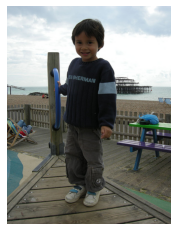

1/1 [==============================] - 0s 16ms/step
two children are playing on trampoline
BLEU-1: 0.119422
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


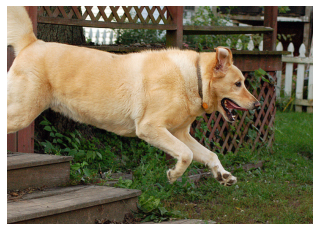

1/1 [==============================] - 0s 18ms/step
two dogs are playing together on the grass
BLEU-1: 0.250000
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


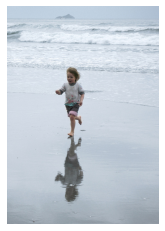

1/1 [==============================] - 0s 20ms/step
young boy in blue shorts is playing with water
BLEU-1: 0.397706
BLEU-2: 0.000000
BLEU-3: 0.000000
BLEU-4: 0.000000


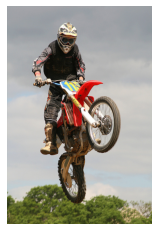

1/1 [==============================] - 0s 18ms/step
man on motorcycle is riding on dirt road
BLEU-1: 0.375000
BLEU-2: 0.327327
BLEU-3: 0.000000
BLEU-4: 0.000000


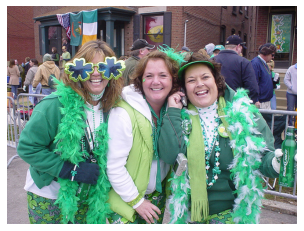

1/1 [==============================] - 0s 18ms/step
two women in dresses dresses dance
BLEU-1: 0.238844
BLEU-2: 0.185008
BLEU-3: 0.000000
BLEU-4: 0.000000


In [74]:
for i in range(5):
    rn =  np.random.randint(0, 1000)
    img_name = list(encoding_test.keys())[rn]
    photo = encoding_test[img_name].reshape((1,2048))

    i = plt.imread(images+img_name)
    plt.imshow(i)
    plt.axis("off")
    plt.show()

    caption = predict_caption(photo)
    print(caption)
    name = img_name.split(".")[0]
    actual = descriptions[name]
    ref1 = actual[0].split()
    ref2 = actual[1].split()
    ref3 = actual[2].split()
    ref4 = actual[3].split()
    ref5 = actual[4].split()

    hypothesis1 = caption.split()

    # BLEUscore = sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1)
    # BLEUscore = nltk.translate.bleu_score.sentence_bleu(reference, hypothesis)
    print('BLEU-1: %f' % sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1, weights=(1.0, 0, 0 ,0)))
    # print('BLEU-1: %f' % corpus_bleu(reference, caption.split(), weights=(1.0, 0, 0, 0,0)))
    print('BLEU-2: %f' % sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % sentence_bleu([ref1, ref2, ref3, ref4, ref5], hypothesis1, weights=(0.25, 0.25, 0.25, 0.25)))